In [14]:
import pandas as pd
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np


def create_data_loader(file_name='weather_data.csv', batch_size=1, model="SO"):
	# Load the CSV file
	df = pd.read_csv(file_name)  # Replace with your file path

	# Step 1: Extract nodes and edges
	nodes = df['node_id'].unique()
	node_to_idx = {node: idx for idx, node in enumerate(nodes)}  # Map node_id to 0-146
	n_nodes = len(nodes)  # 147

	# Parse edge_list to create edge_index
	edge_list = []
	for _, row in df.iterrows():
		source = node_to_idx[row['node_id']]
		targets = eval(row['edge_list'])  # Convert string "[1, 99, ...]" to list
		for target in targets:
			edge_list.append([source, node_to_idx[target]])

	edge_index = torch.tensor(edge_list, dtype=torch.long).t()  # Shape: [2, E]
	# Ensure undirected: add reverse edges
	edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
	# Remove duplicates
	edge_index = torch.unique(edge_index, dim=1, sorted=True)

	# Step 2: Define weather features and normalize
	# weather_features = [
	# 	'latitude', 'longitude',
	# 	'temperature_max', 'temperature_min', 'temperature_mean',
	# 	'precipitation_sum', 'snowfall_sum', 'relative_humidity_max',
	# 	'relative_humidity_min', 'dewpoint_max', 'dewpoint_min'
	# ]
	weather_features = [
			"street_count",			# node degree
			"latitude",
			"longitude",
			"temperature_max",       # index 0
            "temperature_min",       # index 1
            "temperature_mean",      # index 2
            "sunshine_duration",        # index 3
            "uv_index_max",             # index 4
            "precipitation_sum",        # index 5
            "snowfall_sum",             # index 6
            "rain_sum",                 # index 7
            "precipitation_hours",      # index 8
            "precipitation_probability_max",  # index 9
            "wind_speed_10m_max",       # index 10
            "wind_gusts_10m_max"        # index 11
	]

	# Compute mean and std across all data
	means = df[weather_features].mean()
	stds = df[weather_features].std()
	stds[stds == 0] = 1e-10  # Avoid division by zero

	def standardize(df_day):
		return (df_day[weather_features] - means) / stds
	
	def min_max_normalize(df_day, epsilon=1e-8):
		# Create a copy of the dataframe to avoid modifying the original
		df_normalized = df_day.copy()
    
		# Ensure the specified columns are numeric
		# df_normalized[weather_features] = df_normalized[weather_features].apply(pd.to_numeric, errors='coerce')
		
		# Compute the min and max for each feature
		min_vals = df_normalized[weather_features].min()
		max_vals = df_normalized[weather_features].max()
		
		# Compute the range and replace 0 with epsilon to avoid division by zero
		diff = max_vals - min_vals
		diff = diff.replace(0.0, epsilon)  # or use: np.where(diff == 0, epsilon, diff)
		
		# Apply min-max normalization
		df_normalized[weather_features] = (df_normalized[weather_features] - min_vals) / diff
		
		# Print the normalized features for verification
		# print(df_normalized[weather_features])
		
		return df_normalized

	# Step 3: Define edge labels
	def compute_edge_labels(df_day, edge_index):
		temp_min = df_day['temperature_min'].values
		precip = df_day['precipitation_sum'].values
		snow = df_day['snowfall_sum'].values
		labels = []
		for i in range(edge_index.size(1)):
			u, v = edge_index[:, i].tolist()
			min_temp = min(temp_min[u], temp_min[v])
			max_precip = max(precip[u], precip[v])
			max_snow = max(snow[u], snow[v])
			icy = min_temp < 0 and (max_precip > 0 or max_snow > 0)
			labels.append(1 if icy else 0)
		return torch.tensor(labels, dtype=torch.float)
	

	def compute_edge_labels_more_sophisticated_model(df_day, edge_index, wind_threshold=20, sunshine_threshold=4):
		# Extract relevant features from the dataframe
		temp_min = df_day['temperature_min'].values
		temp_max = df_day['temperature_max'].values
		precip_sum = df_day['precipitation_sum'].values
		snowfall_sum = df_day['snowfall_sum'].values
		rain_sum = df_day.get('rain_sum', pd.Series(0, index=df_day.index)).values  # Default to 0 if not present
		max_wind_speed = df_day['wind_speed_10m_max'].values
		sunshine_duration = df_day['sunshine_duration'].values
		
		labels = []
		for i in range(edge_index.size(1)):
			# Get the nodes (u, v) for the current edge
			u, v = edge_index[:, i].tolist()
			
			# Compute min/max values across the edge's nodes
			min_temp = min(temp_min[u], temp_min[v])
			max_temp = max(temp_max[u], temp_max[v])
			precip = max(precip_sum[u], precip_sum[v])
			snow = max(snowfall_sum[u], snowfall_sum[v])
			rain = max(rain_sum[u], rain_sum[v])
			wind = max(max_wind_speed[u], max_wind_speed[v])
			sunshine = max(sunshine_duration[u], sunshine_duration[v])
			
			# Base condition: icy if min_temp < 0 and precipitation or snow present
			base_icy = min_temp < 0 and (precip > 0 or snow > 0)
			score = 1.0 if base_icy else 0.0
			
			# Refinement 1: Temperature Drop - increase probability for refreezing
			if max_temp > 0 and min_temp < 0 and precip > 0:
				score += 0.2
			
			# Refinement 2: Moisture Context
			if rain > 0 and min_temp > 0:
				score -= 0.1  # Decrease probability if rain and above freezing
			if snow > 0 and min_temp < 0:
				score += 0.1  # Increase probability if snow and below freezing
			
			# Refinement 3: Drying/Melting - decrease probability if windy or sunny
			if wind > wind_threshold or sunshine > sunshine_threshold:
				score -= 0.1
			
			# Ensure score stays between 0 and 1
			score = max(0.0, min(1.0, score))
			
			# Threshold the score to get a binary label
			icy = 1 if score > 0.5 else 0
			labels.append(icy)
		
		return torch.tensor(labels, dtype=torch.float)

	# Step 4: Create Data objects for each day
	dates = sorted(df['date'].unique())  # 8 unique dates
	data_list = []
	for date in dates:
		df_day = df[df['date'] == date].sort_values('node_id')  # Ensure consistent node order
		# x = standardize(df_day).values  # Shape: [147, 9]
		x = min_max_normalize(df_day)[weather_features].values
		

		x = torch.tensor(x, dtype=torch.float)
		if model=="SO":
			edge_labels = compute_edge_labels(df_day, edge_index)
		else:
			edge_labels = compute_edge_labels_more_sophisticated_model(df_day, edge_index)
		
		data = Data(
			x=x,
			edge_index=edge_index,
			edge_label_index=edge_index,  # Predict all edges
			edge_label=edge_labels
		)
		data_list.append(data)

	# Step 5: Create DataLoader
	loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)  # Batch size 1 for 8 days
	return loader



In [9]:

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

def visualize_graph(edge_index, edge_labels, title, pos=None):
    """
    Visualizes a graph with edges colored based on labels.
    
    Parameters:
    - edge_index: Tensor of shape [2, num_edges] representing graph edges.
    - edge_labels: Tensor of shape [num_edges] with binary labels (0 or 1).
    - title: Title of the plot (e.g., "Ground Truth Icy Roads").
    - pos: Optional; precomputed layout positions for consistency.
    
    Returns:
    - pos: The layout positions used for the graph.
    """
    # Create a NetworkX graph from edge_index
    G = nx.Graph()
    edges = edge_index.t().tolist()  # Convert edge_index to list of edge tuples
    G.add_edges_from(edges)
    
    # Assign colors to edges based on labels (red for icy, black for normal)
    colors = ['red' if label == 1 else 'black' for label in edge_labels]
    
    # Draw the graph with specified colors
    if pos is None:
        pos = nx.spring_layout(G)  # Compute layout if not provided
    nx.draw(G, pos, node_color='black', edge_color=colors, with_labels=False, 
            node_size=5, font_color='white', width=0.5)
    plt.title(title)
    plt.show()
    return pos

class GNNEdgePredictor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNEdgePredictor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.3)  # 30% dropout
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after first convolution
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second convolution
        # Edge prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_pred = self.mlp(edge_features).squeeze()
        return torch.sigmoid(edge_pred)  # Probability of icy road
    
class GATEdgePredictor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GATEdgePredictor, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim, heads=4, concat=True)
        self.gat3 = GATConv(hidden_dim * 4, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.3)  # 30% dropout
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after first convolution
        x = self.gat2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second convolution
        x = self.gat3(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second convolution
		# Edge prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_pred = self.mlp(edge_features).squeeze()
        return torch.sigmoid(edge_pred)  # Probability of icy road
    

class SAGEEdgePredictor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SAGEEdgePredictor, self).__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.3)  # 30% dropout
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after first convolution
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout after second convolution
        # Edge prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_pred = self.mlp(edge_features).squeeze()
        return torch.sigmoid(edge_pred)  # Probability of icy road

class CombinedGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CombinedGNN, self).__init__()
        # GCN layer
        self.gcn = GCNConv(input_dim, hidden_dim)
        # GAT layer with 4 attention heads
        self.gat = GATConv(hidden_dim, hidden_dim, heads=4, concat=True)
        # GraphSAGE layer (adjust input for GAT's concatenated output)
        self.sage = SAGEConv(hidden_dim * 4, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.3)  # 30% dropout
        # MLP for edge prediction
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Dropout after GCN
        x = self.gat(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Dropout after GAT
        x = self.sage(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # Dropout after GraphSAGE
        # Edge prediction: concatenate embeddings of edge endpoints
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_pred = self.mlp(edge_features).squeeze()
        return torch.sigmoid(edge_pred)



# Training loop
def train(model, loader, optimizer, criterion, epochs=1000):
	scheduler = StepLR(optimizer, step_size=100, gamma=0.5)  # Halve LR every 100 epochs
	model.train()
	losses = []
	for epoch in range(epochs):
		total_loss = 0
		# i = 0
		for data in loader:
			# if i <= 3:
				optimizer.zero_grad()
				out = model(data)  # Edge predictions
				loss = criterion(out, data.edge_label)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			# i += 1
		avg_loss = total_loss / 4#len(loader)
		losses.append(avg_loss)

		scheduler.step()  # Update learning rate
		if (epoch + 1) % 50 == 0:
			print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
	return losses

def evaluate_model(model, loader):
	all_preds = []
	all_labels = []
	model.eval()
	i = 0
	with torch.no_grad():
		for data in loader:
			if i >=4:
			# Ground truth labels
				ground_truth_labels = data.edge_label  # Tensor of 0s and 1s
				pred = model(data)
				# print(pred)
				predicted_labels = (pred > 0.7).float()  # Threshold at 0.5
				# print("Predicted icy roads (edge labels):", predicted_labels)
				# Visualize ground truth graph
				pos = visualize_graph(data.edge_index, ground_truth_labels, "Ground Truth Icy Roads")
				
				# Visualize predicted graph with the same layout
				visualize_graph(data.edge_index, predicted_labels, "Predicted Icy Roads", pos=pos)
				all_preds.extend(predicted_labels.numpy())
				all_labels.extend(data.edge_label.numpy())
			i += 1

	test_f1 = f1_score(all_labels, all_preds)
	test_accuracy = accuracy_score(all_labels, all_preds)
	test_precision = precision_score(all_labels, all_preds)
	test_recall = recall_score(all_labels, all_preds)
	print(f'F1-score on test set (192 points, batch size 16): {test_f1:.4f}')
	print(f'Accuracy on test set (192 points, batch size 16): {test_accuracy:.4f}')
	print(f'Precision on test set (192 points, batch size 16): {test_precision:.4f}')
	print(f'Recall on test set (192 points, batch size 16): {test_recall:.4f}')


# Inference example with multiple thresholds and CSV output
def evaluate_and_save_results(model, loader, thresholds=[0.5, 0.6, 0.7, 0.8], output_file='evaluation_results.csv'):
    """
    Evaluate model predictions at different thresholds, compute metrics, and save to CSV.
    
    Parameters:
    - model: Trained GNN model
    - loader: DataLoader with test data
    - thresholds: List of probability thresholds to test
    - output_file: Name of the CSV file to save results
    """
    results = []
    
    model.eval()
    with torch.no_grad():
        all_preds = []  # Store raw probabilities
        all_labels = []  # Store ground truth labels
        
        # Collect all predictions and true labels
        for data in loader:
            # Ground truth labels
            ground_truth_labels = data.edge_label  # Tensor of 0s and 1s
            pred = model(data)  # Raw probabilities
            all_preds.extend(pred.numpy().flatten())
            all_labels.extend(ground_truth_labels.numpy().flatten())
        
        # Convert to numpy arrays for sklearn metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        # Evaluate for each threshold
        for threshold in thresholds:
            predicted_labels = (all_preds > threshold).astype(float)
            
            # Compute metrics
            accuracy = accuracy_score(all_labels, predicted_labels)
            f1 = f1_score(all_labels, predicted_labels, zero_division=0)
            precision = precision_score(all_labels, predicted_labels, zero_division=0)
            recall = recall_score(all_labels, predicted_labels, zero_division=0)
            
            results.append({
                'Threshold': threshold,
                'Accuracy': accuracy,
                'F1-Score': f1,
                'Precision': precision,
                'Recall': recall
            })
            
            # Optional: Visualize for each threshold (commented out for brevity)
            # predicted_binary = torch.tensor(predicted_labels, dtype=torch.float)
            # pos = visualize_graph(data.edge_index, ground_truth_labels, f"Ground Truth Icy Roads (Threshold {threshold})")
            # visualize_graph(data.edge_index, predicted_binary, f"Predicted Icy Roads (Threshold {threshold})", pos=pos)
        
        # Convert results to DataFrame and save to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
        print(results_df)
        return results

c:\Users\eashw\Desktop\PhD_resesarch\multi-period-MD-RPP-RRV\virtual_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training model: GCN
Epoch 50, Loss: 0.5035
Epoch 100, Loss: 0.6181
Epoch 150, Loss: 0.3043
Epoch 200, Loss: 0.2819
Epoch 250, Loss: 0.2563
Epoch 300, Loss: 0.2463
Epoch 350, Loss: 0.2461
Epoch 400, Loss: 0.2500
Epoch 450, Loss: 0.2292
Epoch 500, Loss: 0.2283
Epoch 550, Loss: 0.2212
Epoch 600, Loss: 0.2205
Epoch 650, Loss: 0.2125
Epoch 700, Loss: 0.2179
Epoch 750, Loss: 0.2163
Epoch 800, Loss: 0.2290
Epoch 850, Loss: 0.1986
Epoch 900, Loss: 0.2034
Epoch 950, Loss: 0.2152
Epoch 1000, Loss: 0.2288
Training model: GAT
Epoch 50, Loss: 0.9016
Epoch 100, Loss: 0.3114
Epoch 150, Loss: 0.2425
Epoch 200, Loss: 0.2290
Epoch 250, Loss: 0.2048
Epoch 300, Loss: 0.1934
Epoch 350, Loss: 0.1807
Epoch 400, Loss: 0.1702
Epoch 450, Loss: 0.1617
Epoch 500, Loss: 0.1663
Epoch 550, Loss: 0.1560
Epoch 600, Loss: 0.1540
Epoch 650, Loss: 0.1430
Epoch 700, Loss: 0.1531
Epoch 750, Loss: 0.1600
Epoch 800, Loss: 0.1530
Epoch 850, Loss: 0.1536
Epoch 900, Loss: 0.1648
Epoch 950, Loss: 0.1642
Epoch 1000, Loss: 0.1440


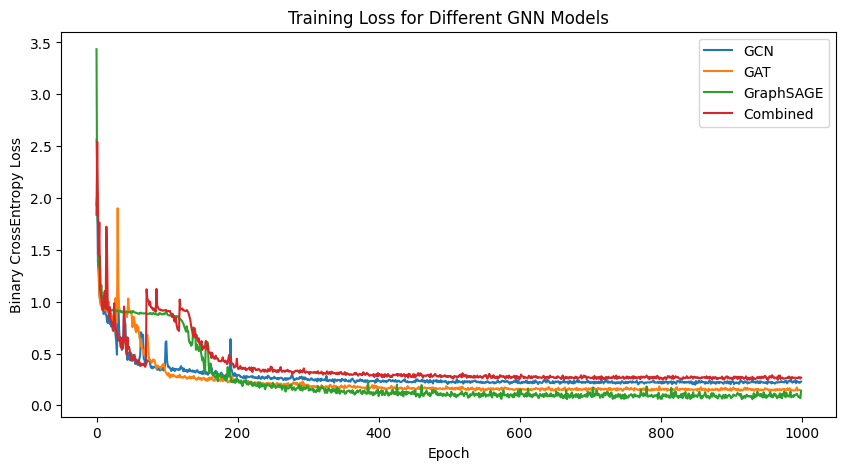

In [15]:
# Create a data loader for efficient data loading
loader = create_data_loader('salt_lake_jan2025.csv', batch_size=1)

# Initialize model
input_dim = 15  # Number of weather features
hidden_dim = 32
batch_size = 1
model_gnn = GNNEdgePredictor(input_dim, hidden_dim)
model_gat = GATEdgePredictor(input_dim, hidden_dim)
model_sage = SAGEEdgePredictor(input_dim, hidden_dim)
model_combined = CombinedGNN(input_dim, hidden_dim)

model_labels = ['GCN', 'GAT', 'GraphSAGE', 'Combined']

models = [model_gnn, model_gat, model_sage, model_combined]
all_losses = []
# Train and plot the training loss for each model
for i, model in enumerate(models):
	print(f"Training model: {model_labels[i]}")
	criterion = torch.nn.BCELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
	losses = train(model, loader, optimizer, criterion)
	torch.save(model, f'{model_labels[i]}.pth')
	all_losses.append(losses)

# Plot the training loss for each model
plt.figure(figsize=(10, 5))
for i, losses in enumerate(all_losses):
	plt.plot(losses, label=model_labels[i])
plt.xlabel('Epoch')
plt.ylabel('Binary CrossEntropy Loss')
plt.title('Training Loss for Different GNN Models')
plt.legend()
plt.show()


In [16]:
loader = create_data_loader('washington_jan2025.csv', batch_size=1)
# evaluate_model(model, loader)
for model in models:
	evaluate_and_save_results(model, loader)

c:\Users\eashw\Desktop\PhD_resesarch\multi-period-MD-RPP-RRV\virtual_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.569124  0.475823   0.665686  0.370229
1        0.6  0.553283  0.434561   0.655666  0.324973
2        0.7  0.542627  0.401658   0.650000  0.290622
3        0.8  0.519585  0.348946   0.614011  0.243730
Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.702477  0.691918   0.763660  0.632497
1        0.6  0.696717  0.682544   0.763318  0.617230
2        0.7  0.688940  0.667283   0.766997  0.590513
3        0.8  0.670219  0.632895   0.768093  0.538168
Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.715726  0.705637   0.778802  0.645038
1        0.6  0.706797  0.691889   0.777551  0.623228
2        0.7  0.702189  0.681650   0.782885  0.603599
3        0.8  0.701325  0.674207   0.795404  0.585060
Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Sco

c:\Users\eashw\Desktop\PhD_resesarch\multi-period-MD-RPP-RRV\virtual_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training model: GCN
Epoch 50, Loss: 0.6763
Epoch 100, Loss: 0.4697
Epoch 150, Loss: 0.3924
Epoch 200, Loss: 0.3290
Epoch 250, Loss: 0.3158
Epoch 300, Loss: 0.3000
Epoch 350, Loss: 0.2852
Epoch 400, Loss: 0.2832
Epoch 450, Loss: 0.2694
Epoch 500, Loss: 0.2625
Epoch 550, Loss: 0.2633
Epoch 600, Loss: 0.2545
Epoch 650, Loss: 0.2541
Epoch 700, Loss: 0.2581
Epoch 750, Loss: 0.2473
Epoch 800, Loss: 0.2593
Epoch 850, Loss: 0.2518
Epoch 900, Loss: 0.2457
Epoch 950, Loss: 0.2499
Epoch 1000, Loss: 0.2422
Training model: GAT
Epoch 50, Loss: 0.6259
Epoch 100, Loss: 0.3430
Epoch 150, Loss: 0.2966
Epoch 200, Loss: 0.2598
Epoch 250, Loss: 0.2376
Epoch 300, Loss: 0.2448
Epoch 350, Loss: 0.2272
Epoch 400, Loss: 0.1885
Epoch 450, Loss: 0.1855
Epoch 500, Loss: 0.1729
Epoch 550, Loss: 0.1826
Epoch 600, Loss: 0.1937
Epoch 650, Loss: 0.1813
Epoch 700, Loss: 0.1757
Epoch 750, Loss: 0.1847
Epoch 800, Loss: 0.1767
Epoch 850, Loss: 0.1707
Epoch 900, Loss: 0.1822
Epoch 950, Loss: 0.1861
Epoch 1000, Loss: 0.1810


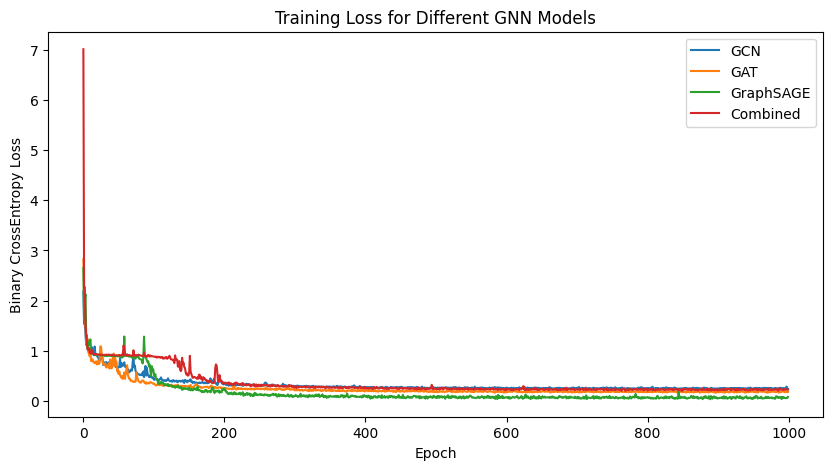

In [17]:
# Create a data loader for efficient data loading
loader = create_data_loader('salt_lake_jan2025.csv', batch_size=1)

# Initialize model
input_dim = 15  # Number of weather features
hidden_dim = 32
batch_size = 1
model_gnn = GNNEdgePredictor(input_dim, hidden_dim)
model_gat = GATEdgePredictor(input_dim, hidden_dim)
model_sage = SAGEEdgePredictor(input_dim, hidden_dim)
model_combined = CombinedGNN(input_dim, hidden_dim)

model_labels = ['GCN', 'GAT', 'GraphSAGE', 'Combined']

models = [model_gnn, model_gat, model_sage, model_combined]
all_losses = []
# Train and plot the training loss for each model
for i, model in enumerate(models):
	print(f"Training model: {model_labels[i]}")
	criterion = torch.nn.BCELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
	losses = train(model, loader, optimizer, criterion)
	torch.save(model, f'{model_labels[i]}_sophisticated_rule.pth')
	all_losses.append(losses)

# Plot the training loss for each model
plt.figure(figsize=(10, 5))
for i, losses in enumerate(all_losses):
	plt.plot(losses, label=model_labels[i])
plt.xlabel('Epoch')
plt.ylabel('Binary CrossEntropy Loss')
plt.title('Training Loss for Different GNN Models')
plt.legend()
plt.show()


c:\Users\eashw\Desktop\PhD_resesarch\multi-period-MD-RPP-RRV\virtual_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.778111  0.748375   0.744000  0.752802
1        0.6  0.774563  0.741714   0.744975  0.738481
2        0.7  0.765830  0.727964   0.741602  0.714819
3        0.8  0.755459  0.709468   0.740189  0.681196
Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.783570  0.757566   0.744144  0.771482
1        0.6  0.776747  0.746749   0.742611  0.750934
2        0.7  0.757642  0.717737   0.733117  0.702989
3        0.8  0.730076  0.666442   0.727005  0.615193
Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.849072  0.839197   0.787234  0.898506
1        0.6  0.846343  0.835620   0.786696  0.891034
2        0.7  0.842522  0.830841   0.785042  0.882316
3        0.8  0.840066  0.826832   0.786839  0.871108
Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Sco

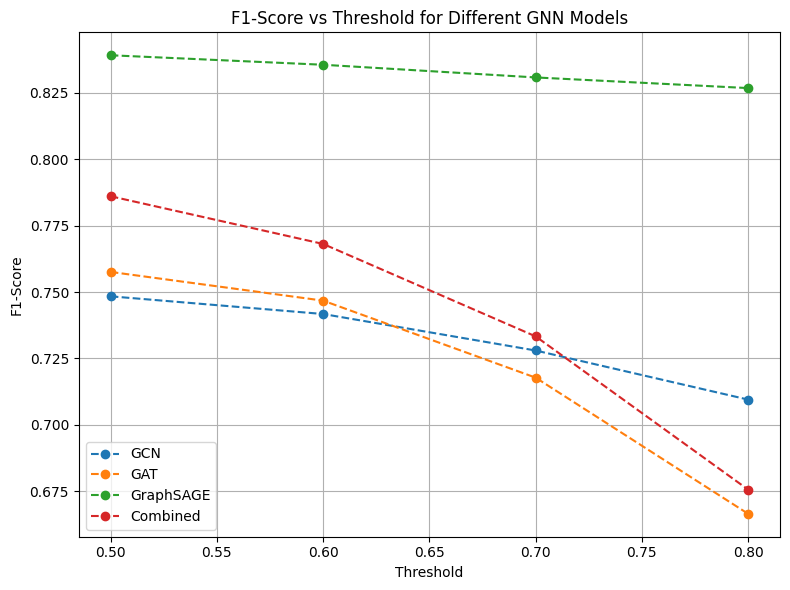

In [16]:
models = []
model_gcn = torch.load('GCN_sophisticated_rule.pth', weights_only=False)
model_gat = torch.load('GAT_sophisticated_rule.pth', weights_only=False)
model_sage = torch.load('GraphSAGE_sophisticated_rule.pth', weights_only=False)
model_combined = torch.load('Combined_sophisticated_rule.pth', weights_only=False)
models.append(model_gcn)
models.append(model_gat)
models.append(model_sage)
models.append(model_combined)
models_name = ['GCN', 'GAT', 'GraphSAGE', 'Combined']
loader = create_data_loader('new_york_jan2025.csv', batch_size=1, model="SOM")
# evaluate_model(model, loader)
plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
	results = evaluate_and_save_results(model, loader)
	ts = []
	f1 = []
	for j in range(len(results)):
		ts.append(results[j]['Threshold'])
		f1.append(results[j]['F1-Score'])
		
	plt.plot(ts, f1, marker='o', linestyle='--', label=models_name[i])

# Labeling the axes and adding a title
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for Different GNN Models')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


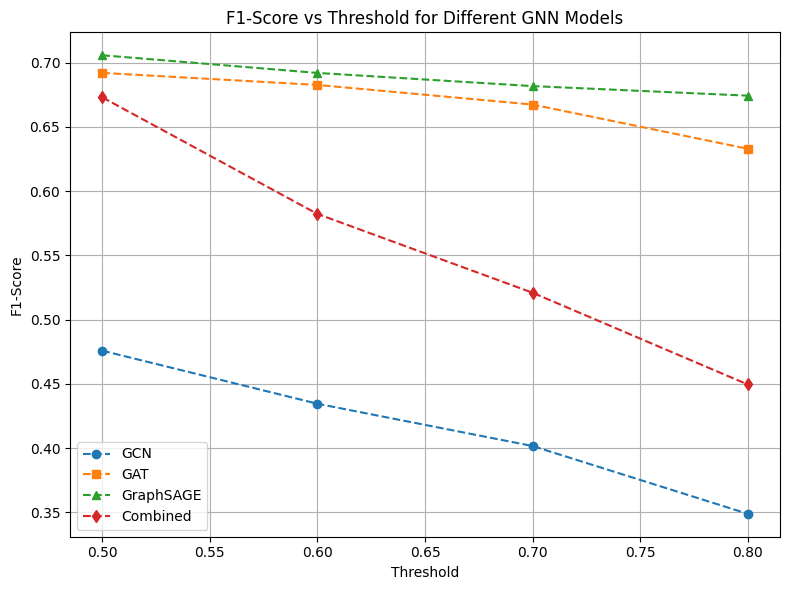

In [2]:
import matplotlib.pyplot as plt

# Data for each model
thresholds = [0.5, 0.6, 0.7, 0.8]

# F1-Scores for each model
f1_gcn = [0.475823, 0.434561, 0.401658, 0.348946]
f1_gat = [0.691918, 0.682544, 0.667283, 0.632895]
f1_graphsage = [0.705637, 0.691889, 0.68165, 0.674207]
f1_combined = [0.672891, 0.582185, 0.520907, 0.449548]

# Create the plot
plt.figure(figsize=(8, 6))

plt.plot(thresholds, f1_gcn, marker='o', linestyle='--', label='GCN')
plt.plot(thresholds, f1_gat, marker='s', linestyle='--', label='GAT')
plt.plot(thresholds, f1_graphsage, marker='^', linestyle='--', label='GraphSAGE')
plt.plot(thresholds, f1_combined, marker='d', linestyle='--', label='Combined')

# Labeling the axes and adding a title
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for Different GNN Models')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


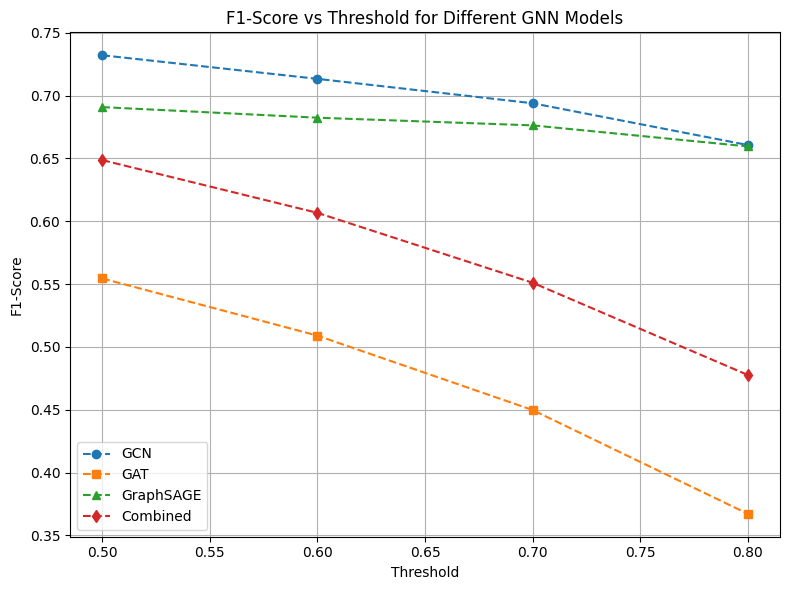

In [3]:
import matplotlib.pyplot as plt

# Define thresholds
thresholds = [0.5, 0.6, 0.7, 0.8]

# F1-Scores for each model based on the provided data
f1_gcn = [0.732132, 0.713353, 0.693952, 0.660714]
f1_gat = [0.554515, 0.508990, 0.449819, 0.367221]
f1_graphsage = [0.690864, 0.682441, 0.676341, 0.659595]
f1_combined = [0.648683, 0.606719, 0.551105, 0.477733]

# Create the plot with a specified figure size
plt.figure(figsize=(8, 6))

# Plot each model's F1-Score vs Threshold with dashed lines
plt.plot(thresholds, f1_gcn, marker='o', linestyle='--', label='GCN')
plt.plot(thresholds, f1_gat, marker='s', linestyle='--', label='GAT')
plt.plot(thresholds, f1_graphsage, marker='^', linestyle='--', label='GraphSAGE')
plt.plot(thresholds, f1_combined, marker='d', linestyle='--', label='Combined')

# Label the axes and add a title
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold for Different GNN Models')

# Add legend and grid for better readability
plt.legend()
plt.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()